# Lab 3 part 2 - Broadcast FM

# <font color='red'> Important! Read this before starting the lab </font>

<font color='red'> You need to patch rtlsdr.py for this lab to work well!! To do this, move the included ``rtlsdr.py`` file to ``~/.local/lib/python3.5/site-packages/rtlsdr/`` on your Pi. </font>


In [1]:
# Import functions and libraries
from __future__ import division
import numpy as np, matplotlib.pyplot as plt
import matplotlib
from numpy import *
from numpy.fft import *
import scipy.signal as signal
from matplotlib.pyplot import *
from rtlsdr import RtlSdr
import rtlsdr
import scipy
#import scipy.iogp
from scipy.io.wavfile import write
import sounddevice as sd
import gc
import pyaudio
%matplotlib inline


Below are some functions from Part I that we will need in this part

In [2]:
# set the default card to be the built-in raspberry-pi audio

sd.default.device = 'bcm2835 ALSA: - (hw:0,0), ALSA'


# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spectrum

def sg_plot( t_range, f_range, y, dbf = 60, fig = None) :
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
 
    fig=figure(figsize=(8,4))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    
    return fig
    
    

## Part II: Broadcast FM Radio


### Task 5: Time-Frequency plots of the radio-frequency spectrum with the SDR.

The samples that are obtained by the SDR represent a bandwidth of the spectrum around a center frequency. Hence, when demodulating to base-band (i.e. zero frequency) the signal must be imaginary since it has a non symmetric Fourier transform. 

In this case, we would like to display both sides of the spectrum.

- Modify the function `myspectrogram_hann_ovlp(x,m,fs,fc)` such that it detects whether the input signal `x` is complex. In that case, it will compute a double sided spectrum with frequency range centered around fc (center frequency). For this, it would be useful to use the commands: `isreal` and `fftshift`.


### Solution:

In [3]:
def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    

    isreal_bool = np.isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = np.append(x,zeros(-lx+nt*m))
    x = x.reshape((m//2,nt*2), order='F')
    x = np.concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m//2,:],dbf=dbf)
        print(1)
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

We will first look at radio FM spectrum. In the US the broadcast FM radio band is  88.1-107.9Mhz. It is split into  200KHz slots. This is relatively a large bandwidth and therefore it is also called wideband FM as opposed to narrowband FM which can be as low as 5 Khz.  In FM radio the information is encoded by modulating the frequency of the carrier,  
$$y_c(t) = A\cos \left (2\pi f_c t + 2\pi \Delta f \int_0^t x(\tau) d\tau \right ).$$

Here, $f_c$ is the carrier frequency,  $\Delta f$ is a frequency deviation scaler and $x(t)$ is a normalized baseband signal, which contains all the information the station wants to broadcast. 

Recall from lab 1, that the instantanious frequency of a signal is the derivative of the phase. For the signal $$y_c(t) = A\cos \left (2\pi f_c t + 2\pi \Delta f \int_0^t x(\tau) d\tau \right )$$, the phase is: $$\phi(t) = 2\pi f_c t + 2\pi \Delta f \int_0^t x(\tau) d\tau$$ and its instantanious frequency is, $$f(t) = \frac{1}{2\pi}\frac{d \phi}{dt} = f_c + \Delta f x(t)$$ -- which is exactly the signal we would like to transmit! 







The signal $x(t)$ is called the baseband signal. It has a frequency content spanning DC to about 100KHz. This is in contrast to the modulated FM signal which has a bandwidth of 200KHz (double sided spectrum) and is present at 88-108MHz. For broadcast FM the baseband signal includes stereo audio, as well as digital information on the station and sometimes additional narrow bandwidth subcarrier channels.
More specifically, the broadcast FM baseband signal, $x(t)$, consists of mono (Left+Right) channels from 30Hz to 15 KHz, a pilot signal at $f_p=19$ KHz, amplitude modulated Stereo (Left - Right) channels around $2\cdot f_p =  38$KHz and digital RBDS, which encodes the station information, song name etc.  at $3\cdot f_p =57$KHz.  (See <http://en.wikipedia.org/wiki/FM_broadcasting> for more information). 

The baseband signal is:

$ \qquad \qquad x(t) = \underbrace{(L+R)}_{\mathrm{mono}} + \underbrace{0.1 \cdot \cos(2\pi f_p t)}_\mathrm{pilot} +  \underbrace{(L-R)\cos(2\pi (2f_p) t)}_\mathrm{stereo}  + \underbrace{0.05\cdot \mathrm{RBDS}(t)\cos(2\pi (3f_p) t)}_\mathrm{digital~ RBDS} + \mathrm{subcarriers~signals}. $

The signal $\mathrm{RBDS}(t)$ is a $m(t)\cos(2\pi(3(f_p))$ where $m(t)$ is a binary signal consists of $\pm1$ at constant intervals which encode 0, and 1 bits. The subcarriers are often FM modulated signals of foreign stations or carry other information.
This is the spectrum of $x(t)$:

<center><img src="./FM.png" alt="FM" style="width: 800px;"/></center>


We will listen to our Berkeley own KPFA 94.1MHz station. KPFA transmitter is located close to Grizzly Peak Road, close to where it meets Claremont Ave.


Recall that our SDR does IQ demodulation around a center frequency of choice, $f_d$, followed by a low-pass filter and sampling. This results in a complex digital signal: $$\qquad \qquad y_b(t) = Ae^{j2\pi (f_c-f_d) t + j2\pi \Delta f \int_0^t x(\tau) d\tau }.$$

When $f_d=f_c$ we get:
$$\qquad \qquad y_b(t) = Ae^{ j2\pi \Delta f \int_0^t x(\tau) d\tau }.$$

We will implement the following system to demodulate and listen to KPFA:
<center><img src="./fmdemod_LPR.png" alt="FM" style="width: 800px;"/></center>

#### Signal Capture:

Like always, you will get the best results if you collect samples outside. 


Task: 
- Set the SDR to sample at a center frequency of 94.1MHz (KPFA) and a rate of 960KHz. We will first Collect 480000 samples, which is exactly 1/2 seconds of data. We acquire only half a second  because computing a spectrogram on more data make take a while on some computers. 
- Compute and display a spectrogram with a window of 1024 samples. Include the spectrogram in your report. What is the spectral and temporal resolution? Explain what you see. 

Tips:
- Don’t forget to play with different dynamic ranges of the spectrogram for best visualization. (40 worked well for me)
- Make sure to set the gain of the SDR so the signal is not under/overloaded! This will make a HUGE difference when demodulating the carriers.

In [4]:
fs = 960000
fc = 94.1e6
sdr = RtlSdr()
sdr.sample_rate = fs    # sampling rate
sdr.center_freq = fc   # center frequency
sdr.gain = 32
N_Samples = 480000
data = sdr.read_samples(N_Samples)   # get samples
sdr.close()

<IPython.core.display.Javascript object>


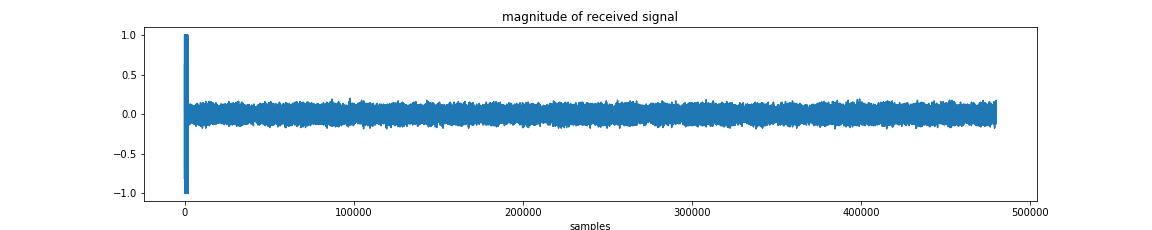

/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [5]:
# Plot. Plotting may take a while!

%matplotlib notebook

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
p = plot((data))
title('magnitude of received signal')
xlabel('samples')




#### Downsampling:

The bandwidth of an FM station is 200KHz. Since we sampled at 960KHz, you may be seeing several stations in the spectrogram. KPFA, the station we are interested in is in the middle around 94.1MHz.  We will need to filter out and select the desired station from the rest of the signals within the spectrum. 

Task:
- Design an FIR filter low-pass filter. The filter should be of  length 128 and the cutoff frequency be 100KHz. This will select the frequencies between -100KHz to 100KHz. To design the filter, we will use the function `signal.firwin` (We will talk more about this filter design technique later in class -- but in essence the function creates a windowed sinc function with the appropriate bandwidth for the given length). 
Type `signal.firwin?` and execute to get help. 

    h = signal.firwin(128,100000.0,nyq=fs/2,window='hanning')

- Plot the double-sided magnitude frequency response (log scale using `plt.semilogy`) by computing a zero-padded FFT to length 1024 and using fftshift. Use KHz as the x-axis units. 




<IPython.core.display.Javascript object>


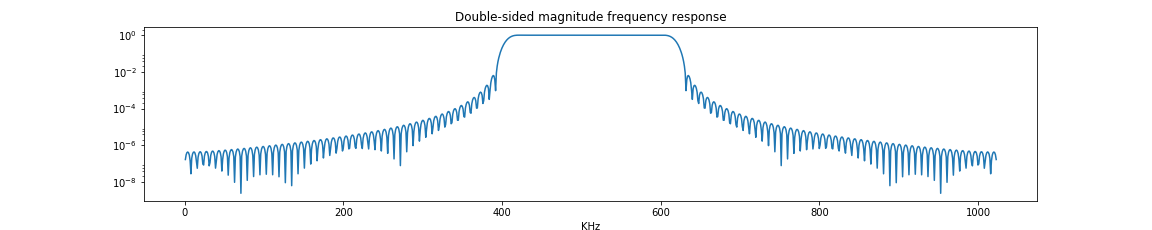

In [6]:
# Your code here

h = signal.firwin(128,100000.0,nyq=fs/2,window='hanning')

N = 1024     # Window size
L= 128        # Length


X = fft(h, N) #zero padding
X = fftshift(X)


# Plotting:

w, h = signal.freqz(X)
f = w * fs/(2*np.pi)

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
semilogy(r_[0.0:N],abs(X))
plt.show()
plt.title('Double-sided magnitude frequency response')
plt.xlabel('KHz')





Now, filter the acquired SDR signal with the low-pass filter. Use the function `numpy.convolve`. Plot the spectrogram of the filtered signal. 

<IPython.core.display.Javascript object>


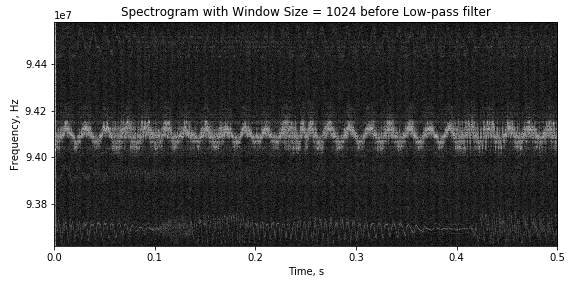

<IPython.core.display.Javascript object>


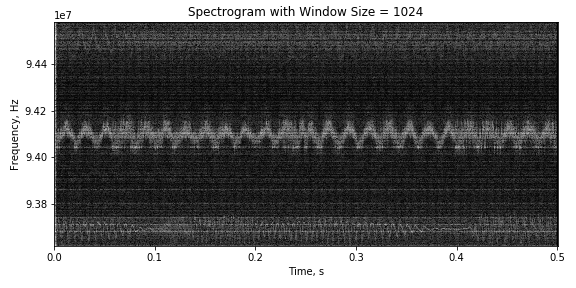

In [7]:
# Your code here

fig = myspectrogram_hann_ovlp(data, 1024, fs, fc, dbf = 60)
plt.show()
plt.title( "Spectrogram with Window Size = 1024 before Low-pass filter" )

data= signal.fftconvolve(data,h,mode='full') #not sure convolve with X or h

fig = myspectrogram_hann_ovlp(data, 1024, fs, fc, dbf = 60)
plt.show()
plt.title( "Spectrogram with Window Size = 1024" )


#found spectrum of KPFA 94.1MHz


Our signal is now bandlimited with a bandwidth of 200KHz out of 960KHz. We can now downsample the signal to reduce computation without aliasing. 

- Decimate the signal by a factor of 4 by selecting every 4th sample, to get a signal representing a rate of 240KHz. After that, you have successfully implemented a downsampler through low-pass filtering and decimation! 

- Plot the spectrogram with a window size of 512. Remember to use the new sampling factor `fs/4.0` for the spectrogram.
- Do you see the rolloff of the low-pass fiter? Is there aliasing?


<IPython.core.display.Javascript object>


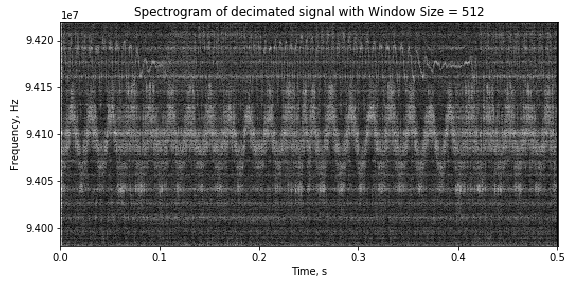

In [8]:
# Your code here

fs1 = fs/4.0

data_dec = data[0::4]

myspectrogram_hann_ovlp(data_dec, 512 , fs1,fc,dbf=60)
plt.title( "Spectrogram of decimated signal with Window Size = 512" )
plt.show()


#yes there is roll off as it is not bandlimited between +- 100kHz
#yes there is aliasing



### Reset memory to continue 

We will reset the variables, so you can continue fresh.

In [46]:
! free -h

              total        used        free      shared  buff/cache   available
Mem:           927M        591M        302M        1.1M         33M        294M
Swap:           99M         99M         20K


In [47]:
%reset -f array

In [48]:
! free -h

              total        used        free      shared  buff/cache   available
Mem:           927M        517M        373M        1.1M         35M        367M
Swap:           99M         99M         20K


Now that you have gone through this processing with 1/2 a second worth of data.  We will acquire a longer segment, which will allow you to appreciate the audio that comes out of it once we demodulate it 

- Acquire 960000*8 samples, which is 8 seconds of data
- Filter and decimate (hence downsample) to the rate of 240KHz. Store the filtered decimated signal in the variable ``data_f``
- Plot the spectrogram ** of the 1st second ** i.e., of the first 240000 samples. 


In [49]:
fs = 960000
fc = 94.1e6
sdr = RtlSdr()
sdr.sample_rate = fs    # sampling rate
sdr.center_freq = fc   # center frequency
sdr.gain = 24.0
N_Samples = 960000*4
data = sdr.read_samples(N_Samples)   # get samples
sdr.close()



<IPython.core.display.Javascript object>


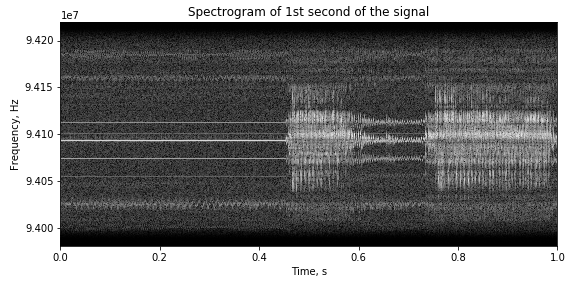

test


In [50]:
# Your code here

h = signal.firwin(128,100000.0,nyq=fs/2,window='hanning')

N = 512     # Window size
L= 128        # Length

X = fft(h, N) #zero padded filter
X = fftshift(X) #center shift


data= signal.fftconvolve(data,h,mode='full') 

fs1 = fs/4.0


#downsampling by factor 4 
data_dec = data[0::4]

myspectrogram_hann_ovlp(data_dec, 512 , fs1 ,fc ,dbf=60)
plt.title( "Spectrogram of 1st second of the signal" )
plt.xlim([0 ,1.0])
print('test')







#### FM Demodulation:

The plot does not resemble the broadcast FM spectrum figure above, since it is not yet FM demodulated. We can easily see that the signal is frequency modulated -- because its frequency looks like the time-signal of  speech or music.

The next step we are going to perform is to demodulate the FM signal and look at its spectrogram. For this we need to find the instantaneous frequency as a function of time, which is the time derivative of the phase. Computing the phase and then taking the derivative will be sensitive to phase wraps, which we would like to avoid. 


Instead, we will take the digital implementation version of the classical FM demodulatation using a limiter, followed by a discriminator. The limiter makes the input have constant amplitude, and the discriminator converts frequency deviations into amplitude modulation. Just as a comment, implementation of an accurate analog disciminator is very difficult whereas implementing a digital one is ridiculously easy!

##### Limiter
Recall that $y_b(t) = A(t)e^{ j2\pi (f_c-f_d) t + j2\pi \Delta f \int_0^t x(\tau) d\tau }.$ The leading coefficient $A(t)$ is some unwanted amplitude modulation, which can be a result of signal fading or other sources of signal variations. The role of the limiter component in an FM radio is to remove this amplitude modulation so the discriminator will only be sensitive to frequency variations. 

In the digital domain, implementing a limiter is done by simply dividing our signal by its amplitude. 

- Apply a limiter to your signal. To avoid dividing by 0, divide your signal by its amplitude plus epsilon, where epsilon = 1e-6 is adequate. Store the result in the same variable ``data_f`` to reduce memory footprint




<IPython.core.display.Javascript object>


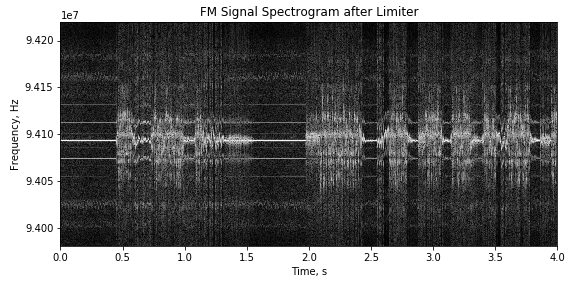

In [51]:
# Your code here


epsilon =1e-6

data_lim=data_dec/(abs(data_dec)+epsilon)

myspectrogram_hann_ovlp(data_lim,512,fs1 ,fc ,dbf=40)
plt.title('FM Signal Spectrogram after Limiter')





##### Discriminator
Assuming that $f_c=f_d$, after the limiter our signal is $ y_b(t)=e^{ j2\pi \Delta f \int_0^t x(\tau) d\tau }.$ To get $x(t)$ we can compute:

$$\left(\frac{d}{dt}y_b(t)\right)y_b^*(t) = j2\pi\Delta f \cdot x(t)\cdot e^{ j2\pi \Delta f \int_0^t x(\tau) d\tau }\cdot e^{  -j2\pi \Delta f \int_0^t x(\tau) d\tau } = j2\pi\Delta f \cdot x(t)$$

Which gives us our desired signal when we take the imaginary part of the result. 


We will need to design a differentiator filter, which its frequency response approximates the ideal frequency response, $H_{diff}(e^{jw}) = w$, of a differentiator. Since we are only going to demodulate up to 105KHz, we can have the differentiator roll of to zero after that. 

- Design an FIR differentiator filter with length 31 using the function `signal.remez` which implements an equi-ripple min-max optimal based filter design technique. It requires prescribing frequency bands and their corresponding frequency responses. We need to tell the function that it's a differentiator so it knows to match a linear frequency response within the band of interest. We will prescribe a linear frequency extending from 0-110KHz and then tapering to zero at the Nyquist frequency 120KHz. As we will learn later in class, since the filter is of even order (odd number of coefficients) and is antisymmetric, its Nyquist frequency must be zero!

Type `signal.remez?` for more information.

Specifically: 

    h_diff = signal.remez(31,[0.0,105000.0,120000.0,120000.0],[1.05/1.2,0],Hz = 240000.0, type='differentiator')
    
will try to get a linear frequency response from 0-105000 and zero amplitude at 120000.

- Plot the filter and its two sided magnitude frequency response (linear scale).




<IPython.core.display.Javascript object>


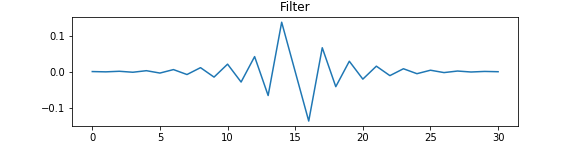

<IPython.core.display.Javascript object>


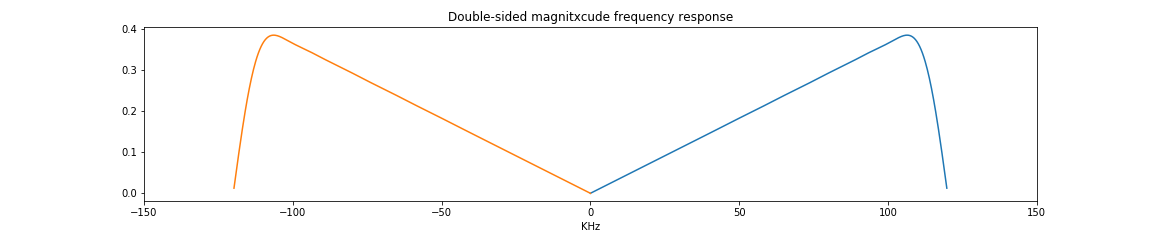

In [52]:
# Your code here

h_diff = signal.remez(31,[0.0,105000.0,120000.0,120000.0],[1.05/1.2,0],Hz = 240000.0, type='differentiator')

w, h = signal.freqz(h_diff)
f = w * 240/(2*np.pi)

#X_diff = fft(h_diff, N) #zero padded filter
#X_diff = fftshift(X_diff) #center shift

#Plotting
fig1 = figure(figsize=(8,2))
p=plot(r_[0:len(h_diff)],h_diff)
plt.title('Filter')

#fig2 = figure(figsize=(8,2))
#p=plot(r_[0:len(X_diff)],X_diff)
#plt.title('Filter after zero padding')


width, height = plt.figaspect(0.2)
fig3 = plt.figure(figsize=(width,height))
plt.plot(f, abs(h),-f,abs(h))
plt.xlim([-150,150])
plt.title('Double-sided magnitxcude frequency response')
plt.xlabel('KHz')




Demodulate the FM signal by first:
- Filter the signal with the differentiator 
- Multiply the result with the conjugate of the original signal
- Take the imaginary component

Note, that the default implementation of `np.convolve` will have a delay of 16 samples with respect to the original signal. **To avoid that, use the option `mode='same'`.**

Note, that after FM demodulating the signal should be real (by taking only the imaginary component) and hence only half the spectrum should be displayed. 

- Plot the spectrogram of the frequency demodulated signal and identify the mono audio, the pilot, the stereo and the RBDS signals. Note, that the RBDS signal may be too weak to detect or may need better spectral resolution. Can you identify the subcarriers? KPFA has two subcarriers, one plays French Hatian radio and the other Punjabi. 

<IPython.core.display.Javascript object>


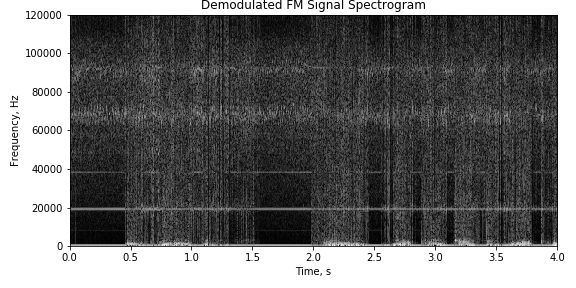

1


In [53]:
# Your code here

data_lim_conj = np.conj(data_lim) #get conjugate of original signal
data_lim =np.convolve(data_lim,h_diff,mode='same') #filter signal with differentiator
data_lim = data_lim * data_lim_conj # multiply result with conjugate
data_lim_imag = data_lim.imag #take imaginary component
#def myspectrogram_hann_ovlp(x, m, fs, fc, dbf = 60, fig = None):

myspectrogram_hann_ovlp(data_lim_imag,512,fs/4, 0, dbf=40) #something went wrong
plt.title('Demodulated FM Signal Spectrogram')




#### Play the mono  (Left  + Right Channel)


The mono signal covers the frequency range of 30Hz-16KHz. However, there are many other signals present. There's another problem. Our sampled signal is at a rate of 240KHz. The soundcard on most modern computers can only deal with a sampling rate of 48KHz. Similarly to the downsampling operation we did before, filter our signal and decimate it before being able to play it. 

- Design a 64 length FIR  Bandpass filter with a cuttoff frequency of 16KHz using the command:

    h = signal.firwin(129,16000.0,nyq=240000.0/2, window='hanning')

- Filter the signal and decimate by a factor of 5 to reduce the rate to 48KHz. Store the result in the a variable called `LPR` (Left + Right). Display the spectrogram of the `LPR`. Use a window length of 256. 





<IPython.core.display.Javascript object>


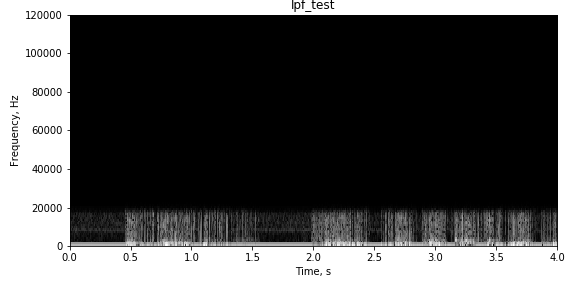

1


<IPython.core.display.Javascript object>


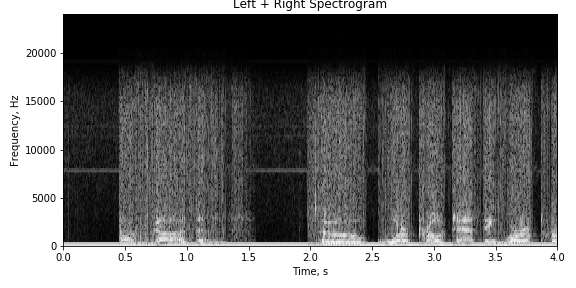

1


In [54]:
# Your code here

h = signal.firwin(129,16000.0,nyq=240000.0/2, window='hanning')
N=256
X = fft(h, 1024) #zero padded filter
#X = fftshift(X) #center shift
#pass through filter
data_filtered = signal.fftconvolve(data_lim_imag, h, mode ='full')
#downsample

myspectrogram_hann_ovlp(data_filtered,256,240000,0.0,dbf = 50)
plt.title('lpf_test')

LPR = data_filtered[0::5]

myspectrogram_hann_ovlp(LPR,256,240000/5,0.0,dbf = 50)
plt.title('Left + Right Spectrogram')

#why am I getting Imaginary portion only?

#### Playing the Mono (Left + Right channel)

- Normalize `LPR` so it is in the range between -1 and 1. 
- Play it. 

Do you hear radio?



In [55]:

# Your code below:


#Normalized LPR
LPR = LPR/max(abs(LPR)+epsilon)



sd.play(LPR,48000,blocking=True)






In [19]:
# Write to wav file
write('fm_LR.wav', 48000, LPR)

#### Demodulating the subcarriers

There are two other signals in the spectrum, centered at 67 kHz, and 92 kHz. These are subsidiary communications authorization (SCA) services. The FCC specifically doesn't regulate the FM band from 57 kHz up to 100 kHz, only requiring that whatever you transmit there doesn't interfere with the principle FM signal. For a long time this extra spectrum was used for Muzak (a generic name for elevator music), and other targeted FM signals. This has become less common with the advent of the internet, but there are still stations that use these channels. KPFA transmits a Hatian-French subchannel at 67 kHz, and a Punjabi subchannel at 92 kHz.

Oddly enough, the subchannels themselves are FM encoded. This is like the Russian Matrushka dolls, with one inside another. Fortunately, you have all the tools you need to decode these signals! 

First, demodulate the subcarrier to baseband. We will then low-pass to separate it from the other signals. Then, we will then downsample it to 48KHz, and then frequency demodulate again using the technique described above.

The entire system is described in the following diagram:

<center><img src="./fmdemod_sc.png" alt="FM" style="width: 800px;"/></center>


To demodulate the subcarrier to baseband -- or zero frequency we will need to:

1. create a time index `t` representing the samples of the signal
2. multiply the frequency demodulated signal in Task 5 with $e^{-2\pi j f_0 t}$ 

Task: Demodulate the frequency demodulated signal in Task 5 by $f_0=67.65$KHz and plot the spectrogram. Since the signal is now complex, you should plot both sides of the spectrum. The subcarrier should be placed at the DC frequency.

<IPython.core.display.Javascript object>


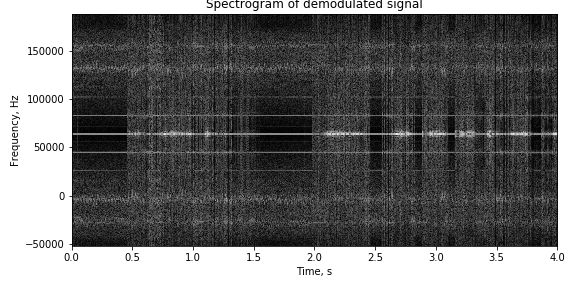

In [56]:
# your code here

#create time index

t= r_[0:len(data_lim_imag)]/(960000*4)

f0= 67650

phase= (-2*np.pi*1j*f0*t)
e= np.exp(phase)

data_d = data_lim_imag * e

myspectrogram_hann_ovlp(data_d,512,fs1 ,f0, dbf = 40)
plt.title('Spectrogram of demodulated signal')





- Design a 129 tap low-pass filter with a bandwidth of $\pm 6$KHz in the passband. 
- Filter the signal and decimate by a factor of 5 to get a signal with a sampling rate of 48KHz. 
- Plot the spectrogram (make sure you adjusted the spectrogram to represent the new sampling rate!). 

do you see aliasing?

<IPython.core.display.Javascript object>


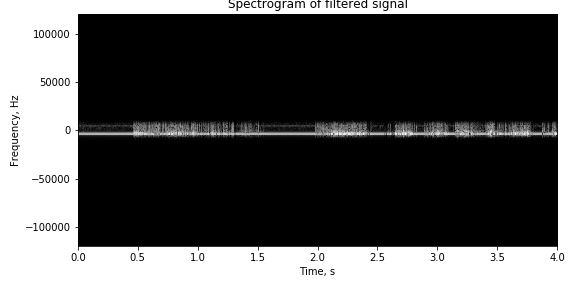

<IPython.core.display.Javascript object>


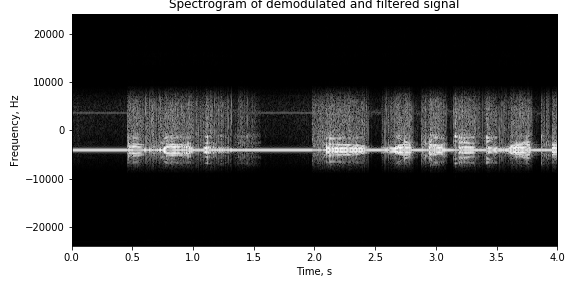

In [57]:
# Your code here

fs2=fs1/5

h = signal.firwin(129,6000.0,nyq=240000.0/2)
#X = fft(h, N) #zero padded filter
#X = fftshift(X) #center shift

data_f1= signal.fftconvolve(data_d,h, mode='full')
myspectrogram_hann_ovlp(data_f1,256,fs1 ,0,dbf =50)
plt.title('Spectrogram of filtered signal')

data_d1 = data_f1[0::5]

myspectrogram_hann_ovlp(data_d1,256,fs2 ,0,dbf = 50)
plt.title('Spectrogram of demodulated and filtered signal')




To frequency demodulate, you will need to apply a limiter as before. The discriminator should be implemented in the same way as before. However, you need to design a new filter which approximates a differentiator between $\pm$8KHz and then tapers to zero. Here's an example:

    h_diff = signal.remez(31,[0.0,8000.0,12000.0,24000],[8.0/24.0,0],Hz = 48000, type='differentiator')

- Perform the limiter operation
- Apply the discriminator using the differentiator filter method. 
- Low-pass the result with a 129 length FIR filter with cutoff of 5KHz to eliminate any residual high frequency noise. Don't forget that the sample rate is 48KHz! 
- Scale the result to be within $\pm1$ and play the audio. 
- Plot the spectrogram of the resulting signal. 

Can you hear French Hatian? 

<IPython.core.display.Javascript object>


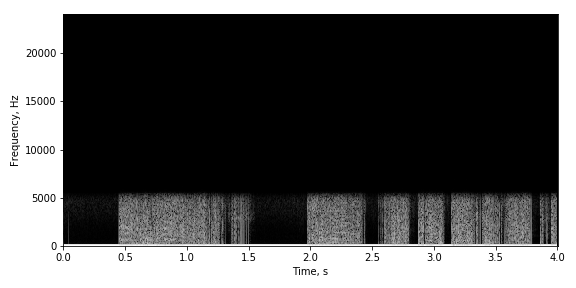

1


In [58]:
#Your code here:

#limiter operation

data_lim1=data_d1/(abs(data_d1)+epsilon)

#differentiatior filter
h_diff = signal.remez(31,[0.0,8000.0,12000.0,24000],[8.0/24.0,0],Hz = 48000, type='differentiator')
#X_diff=fft(h_diff,N)
#X_diff=fftshift(X_diff)


#apply discriminator 

data_lim1_conj = np.conj(data_lim1)
data_lim1 =signal.fftconvolve(data_lim1,h_diff,mode='same') 
data_lim1 = data_lim1 * data_lim1_conj
data_lim1_imag = data_lim1.imag

#low pass FIR filter to denoise
h = signal.firwin(129,5000.0,nyq=48000.0/2)

subc1_demod= signal.fftconvolve(data_lim1_imag,h, mode='full')

#normalize reesult

subc1_demod= subc1_demod/max(abs(subc1_demod))

sd.play(subc1_demod,48000,blocking=True)


#plot spectrogram
myspectrogram_hann_ovlp(subc1_demod,512,fs2 ,0, dbf=50)

write('fm_sc.wav', 48000, subc1_demod)



In [23]:
sd.play(subc1_demod,48000,blocking=True)

Repeat the procedure to play the subcarrier (Punjabi channel) at $f_0=92$ kHz

<IPython.core.display.Javascript object>


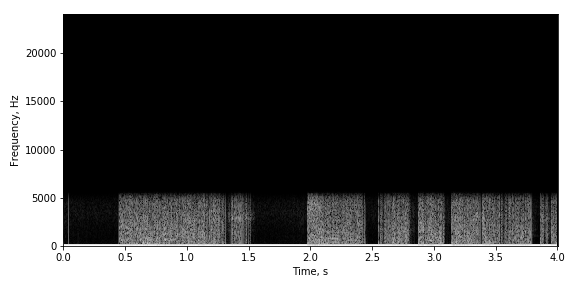

1


In [60]:
# Your code here

#create time index

t= r_[0:len(data_lim_imag)]/(960000*4)
f0= 92000

phase= (-2*np.pi*1j*f0*t)
e1= np.exp(phase)

data_d2 = data_lim_imag * e1

#filter and downsample

fs2=fs1/5.0

h = signal.firwin(129,6000.0,nyq=240000.0/2)
#X = fft(h, N) #zero padded filter
#X = fftshift(X) #center shift

data_f2= signal.fftconvolve(data_d2,h, mode='full')

data_d2=data_f2[0::5]

#limiter operation

data_lim2=data_d2/(abs(data_d2)+epsilon)

#differentiatior filter
h_diff = signal.remez(31,[0.0,8000.0,12000.0,24000],[8.0/24.0,0],Hz = 48000, type='differentiator')
#X_diff=fft(h_diff,N)
#X_diff=fftshift(X_diff)


#apply discriminator 

data_lim2_conj = np.conj(data_lim2)
data_lim2 =signal.fftconvolve(data_lim2,h_diff,mode='same') 
data_lim2 = data_lim2 * data_lim2_conj
data_lim2_imag = data_lim2.imag

#low pass FIR filter
h = signal.firwin(129,5000.0,nyq=48000.0/2)

subc2_demod= signal.fftconvolve(data_lim2_imag,h, mode='full')

#normalize reesult

subc2_demod= subc2_demod/max(abs(subc2_demod))

sd.play(subc2_demod,48000,blocking=True)


#plot spectrogram
myspectrogram_hann_ovlp(subc2_demod,512,fs2 ,0, dbf =50)

write('fm_sc.wav', 48000, subc2_demod)
